# Generative Adversarial Network

#####  Importing Libraries and Packages and downloading Dataset


In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

num_workers = 0
batch_size = 64

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize the data

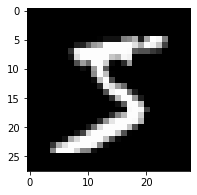

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Define the Model

*   Discriminator
*   Generator



In [4]:
#Discriminator

import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # flattening image
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)

        x = self.fc4(x)
        return x

In [5]:
#Generator

class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)

        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)

        x = torch.tanh(self.fc4(x))        
        return x

In [6]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 28*28
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32



# Generator hyperparams

# Size of latent vector to give to generator
z_size = 150
# Size of discriminator output (generated image)
g_output_size = 28*28
# Size of *first* hidden layer in the generator
g_hidden_size = 32



#Building Complete Network

D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

#### Functions to Calculate losses

In [7]:
def real_loss(D_out, smooth=False):
    size = D_out.size(0)
    if smooth:
      labels = torch.ones(size) * 0.9
    else:
      labels = torch.ones(size)
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    size = D_out.size(0)
    labels = torch.zeros(size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

#### Optimizers


In [8]:
import torch.optim as optim

lr = 0.001

# optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
### Training



In [9]:
import pickle as pkl

num_epochs = 100

samples = []
losses = []

print_every = 400

# constant throughout training to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
       

        #______________TRAINING THE DISCRIMINATOR______________

        d_optimizer.zero_grad()

        # Computing the discriminator losses on real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        # Generating fake images for training
        z = np.random.uniform(-1, 1, size=(batch_size, z_size)) #z_size is size of latent vector
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Computing the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        # adding up real and fake losses and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        


        #______________TRAINING THE GENERATOR______________

        g_optimizer.zero_grad()
        
        # Generating fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Computing the discriminator losses on fake images using flipped labels
        d_fake = D(fake_images)
        g_loss = real_loss(d_fake)

        # performing backprop
        g_loss.backward()
        g_optimizer.step()
        

        # Printing loss stats
        if batch_i % print_every == 0:
            # discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # appending discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Saving training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3955 | g_loss: 0.6991
Epoch [    1/  100] | d_loss: 1.1076 | g_loss: 1.6428
Epoch [    1/  100] | d_loss: 1.7638 | g_loss: 0.9658
Epoch [    2/  100] | d_loss: 0.9955 | g_loss: 1.5760
Epoch [    2/  100] | d_loss: 1.3218 | g_loss: 1.4587
Epoch [    2/  100] | d_loss: 1.3236 | g_loss: 0.9831
Epoch [    3/  100] | d_loss: 1.3211 | g_loss: 0.7689
Epoch [    3/  100] | d_loss: 0.7543 | g_loss: 1.9420
Epoch [    3/  100] | d_loss: 0.7103 | g_loss: 2.4172
Epoch [    4/  100] | d_loss: 0.8082 | g_loss: 2.5555
Epoch [    4/  100] | d_loss: 0.8431 | g_loss: 2.0625
Epoch [    4/  100] | d_loss: 1.1297 | g_loss: 1.4772
Epoch [    5/  100] | d_loss: 1.0788 | g_loss: 2.4661
Epoch [    5/  100] | d_loss: 0.9232 | g_loss: 2.4370
Epoch [    5/  100] | d_loss: 1.0018 | g_loss: 1.5337
Epoch [    6/  100] | d_loss: 1.1031 | g_loss: 1.4697
Epoch [    6/  100] | d_loss: 1.1442 | g_loss: 1.1106
Epoch [    6/  100] | d_loss: 1.1142 | g_loss: 1.1763
Epoch [    7/  100] | d_loss

#### Training loss


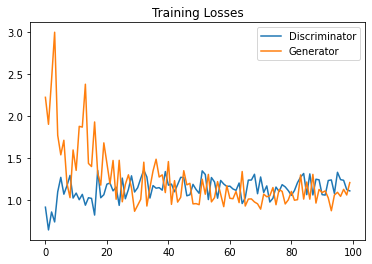

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

#### Generator samples from training


In [10]:
# helper function for viewing a list of passed in sample images

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

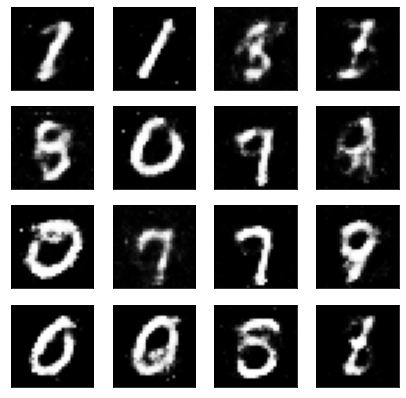

In [11]:
# Load samples from generator, taken while training

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples)

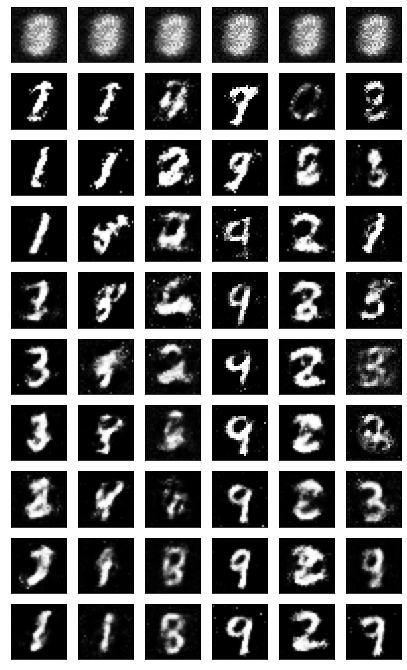

In [12]:
rows = 10       #split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

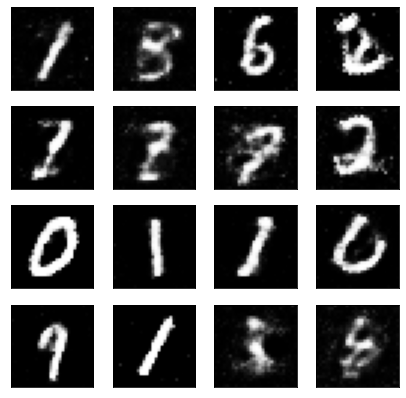

In [13]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])